- day + animal + sex
- experiment + animal + sex
- comparison top 10 to rest in both


Expectations:
- variation across different experiments and gap lengths
- stronger in female mice
- variation across recording days without pattern
- stronger in first 10 recordings

In [27]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats as stats
import re
import seaborn as sns
import os
from itertools import combinations
import inspect

In [28]:
input_dir = "Results" # input directory

number = 1 # result number (subfolder name)

In [29]:
results_dir = os.path.join(input_dir, str(number))
files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

file_path = os.path.join(results_dir, files[0])
df = pd.read_excel(file_path)

file_path_top_10 = os.path.join(results_dir, files[1])
df_top_10 = pd.read_excel(file_path_top_10)

In [30]:
def plot_results(df=df, strength=False, by_date=False):
    if not by_date:
        # Group by experiment and sex, averaging reactionTime across animals and dates
        grouped_df = df.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength'].mean() if strength else df.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime'].mean()

        # Preserve the order of experiments
        experiment_order = df['experiment'].drop_duplicates().tolist()
        grouped_df['experiment'] = pd.Categorical(grouped_df['experiment'], categories=experiment_order, ordered=True)

        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=grouped_df,
            x='experiment',
            y='strength' if strength else 'reactionTime',
            hue='sex',
            order=experiment_order,
            errorbar=None
        )

        plt.xticks(rotation=45, ha='right')
        plt.title("Average Strength per Experiment") if strength else plt.title("Average Reaction Time per Experiment")
        plt.ylabel("Average Strength") if strength else plt.ylabel("Average Reaction Time")
        plt.xlabel("Experiment")
        plt.tight_layout()
        plt.show()
        
    else:
        experiment_order = df['experiment'].drop_duplicates().tolist()

        unique_dates = df['date'].unique()

        for date in unique_dates:
            df_date = df[df['date'] == date]

            grouped = df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['strength'].mean() if strength else df_date.groupby(['experiment', 'sex'], as_index=False, observed=True)['reactionTime'].mean()

            grouped['experiment'] = pd.Categorical(grouped['experiment'], categories=experiment_order, ordered=True)

            plt.figure(figsize=(12, 6))
            sns.barplot(
                data=grouped,
                x='experiment',
                y='strength' if strength else 'reactionTime',
                hue='sex',
                order=experiment_order,
                errorbar=None
            )

            plt.title(f"Average Strength per Experiment - {date}") if strength else plt.title(f"Average Reaction Time per Experiment - {date}")
            plt.xticks(rotation=45, ha='right')
            plt.ylabel("Average Strength") if strength else plt.ylabel("Average Reaction Time")
            plt.xlabel("Experiment")
            plt.tight_layout()
            plt.show()

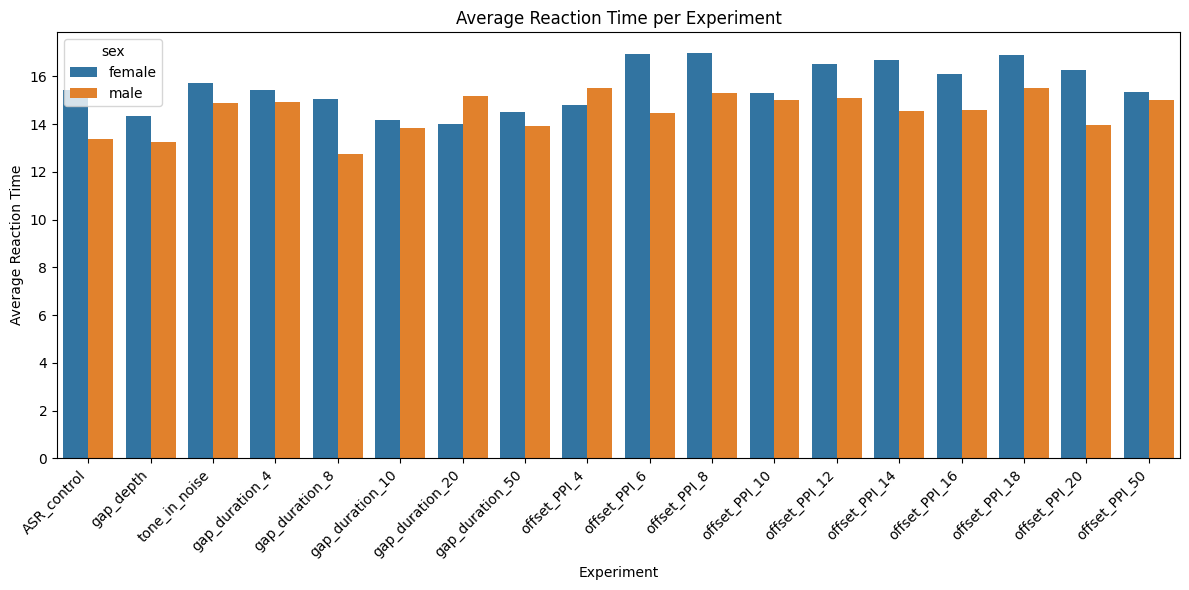

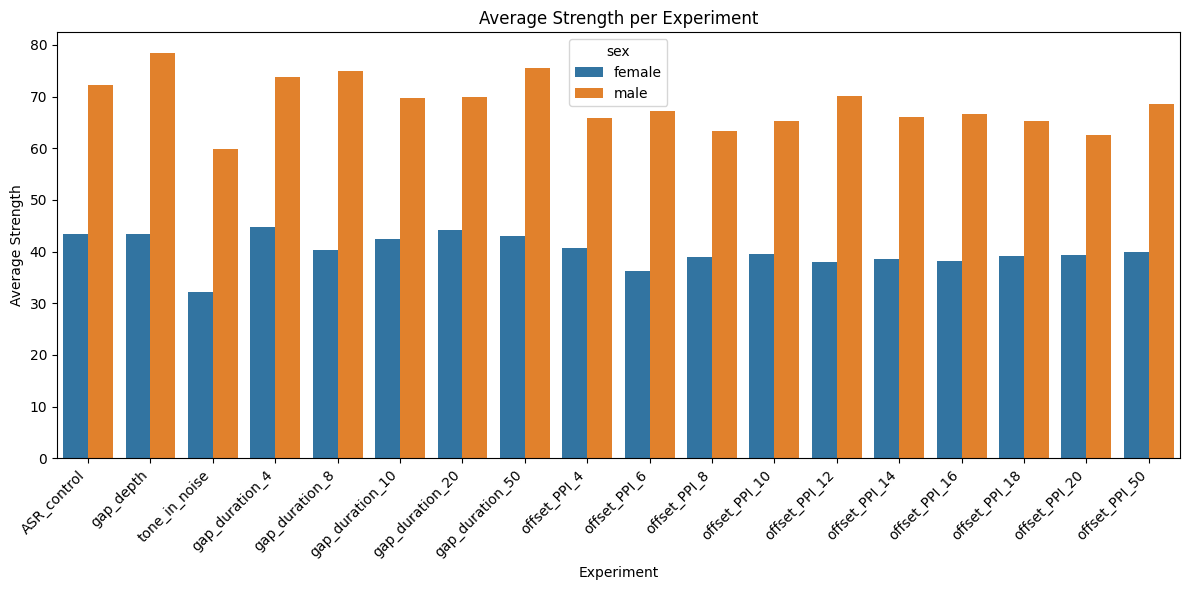

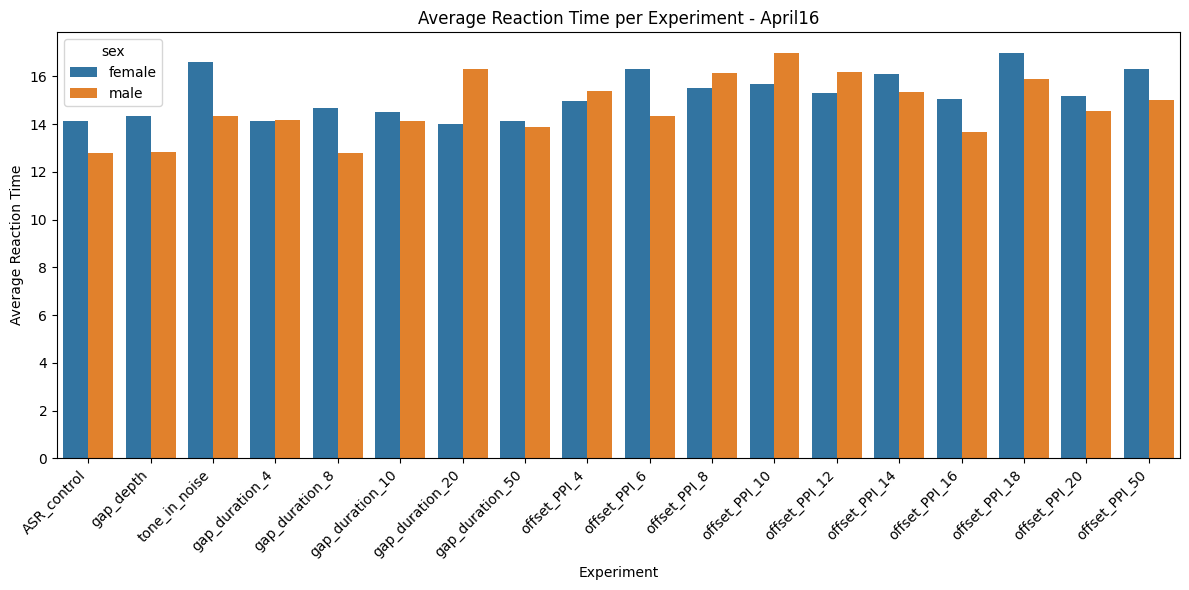

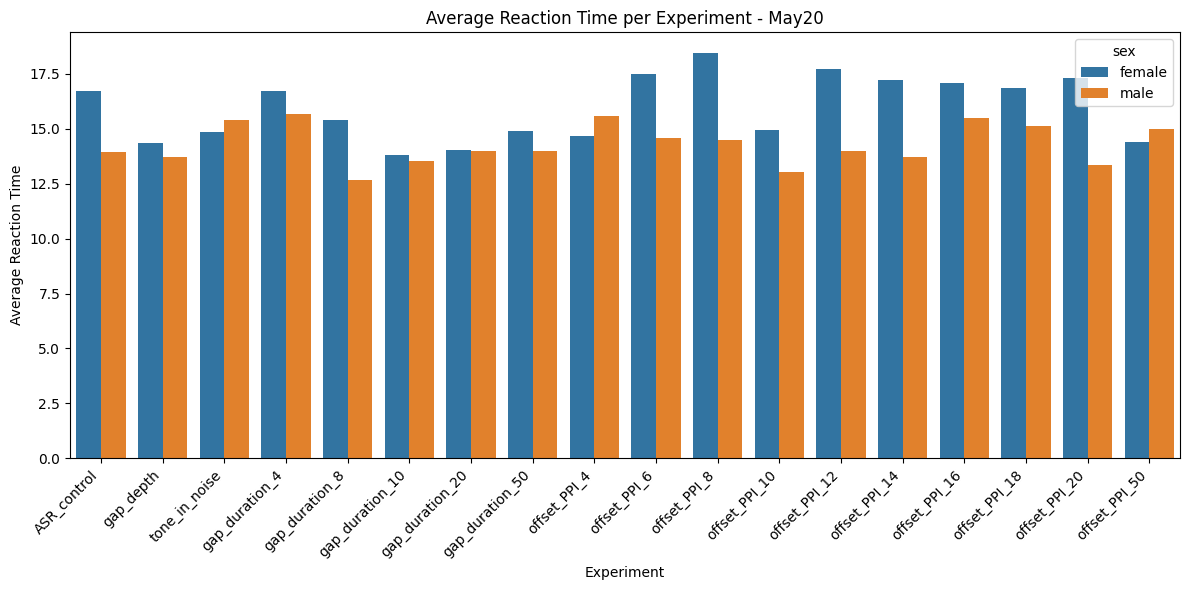

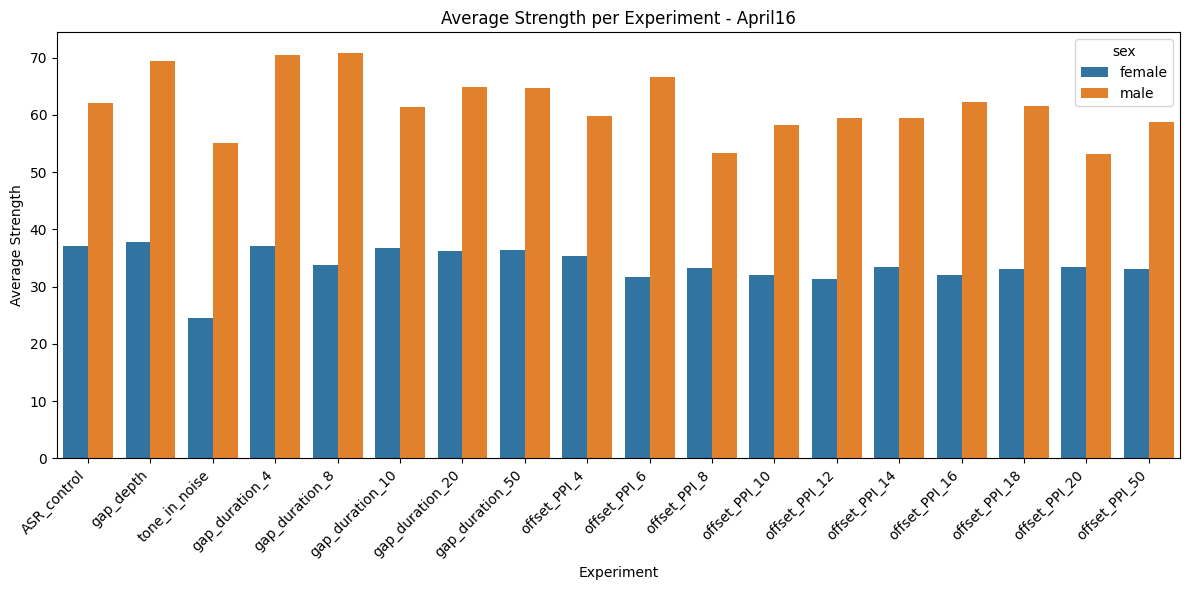

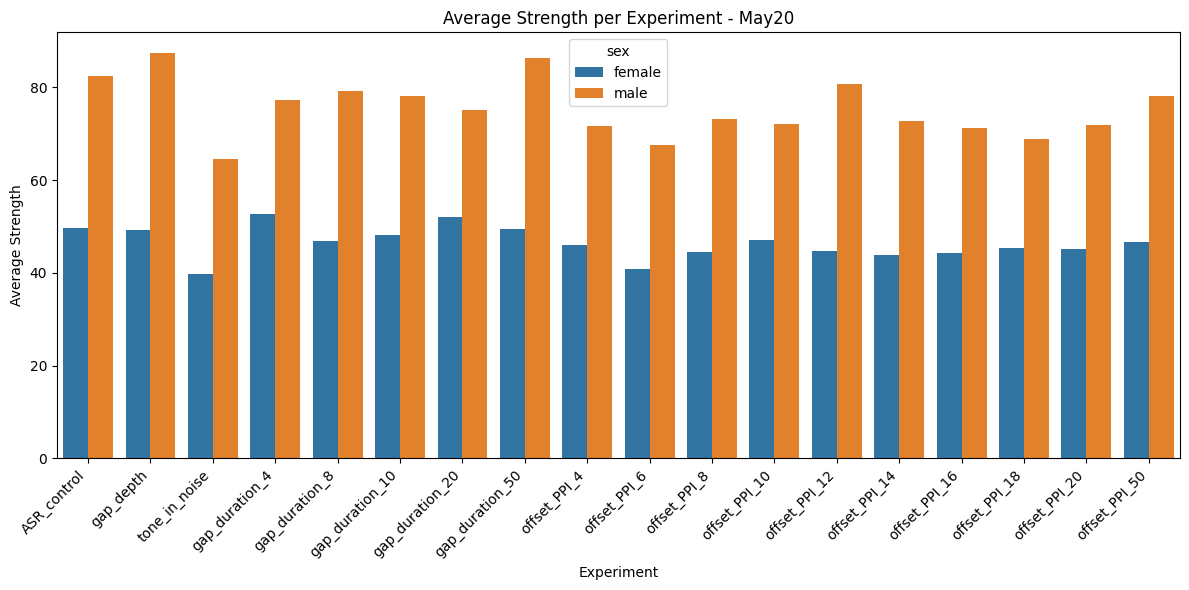

Top 10:


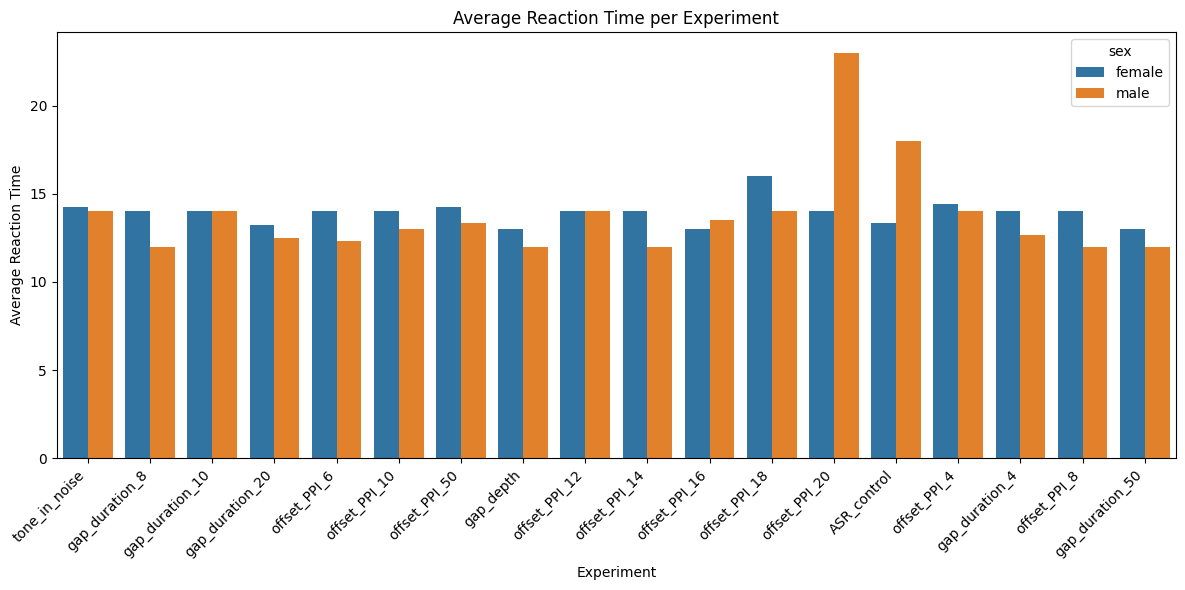

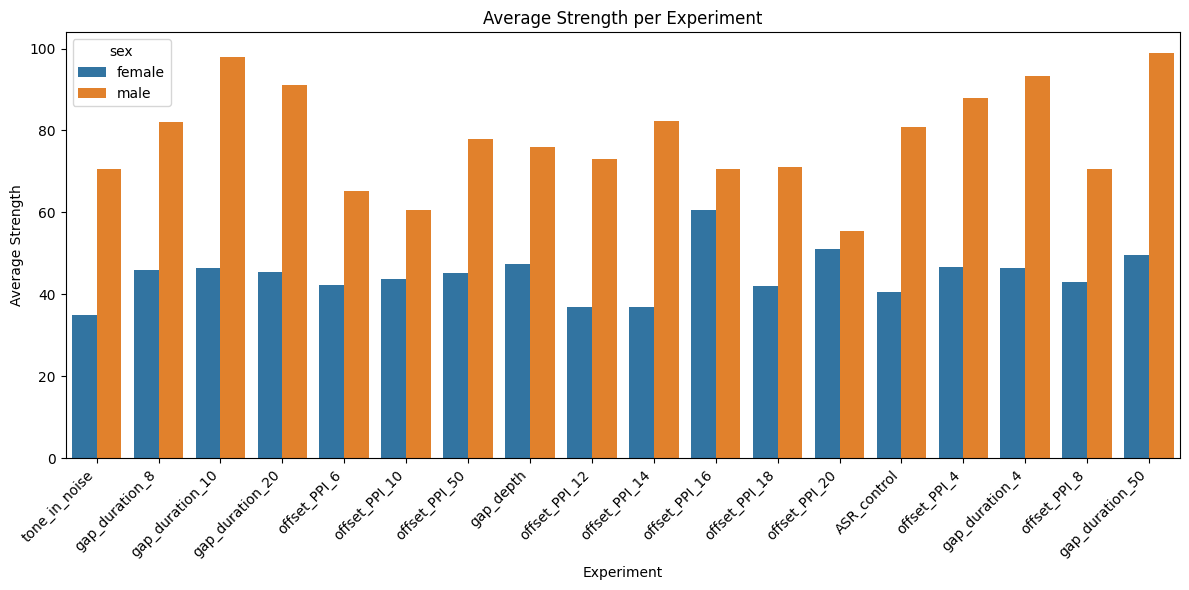

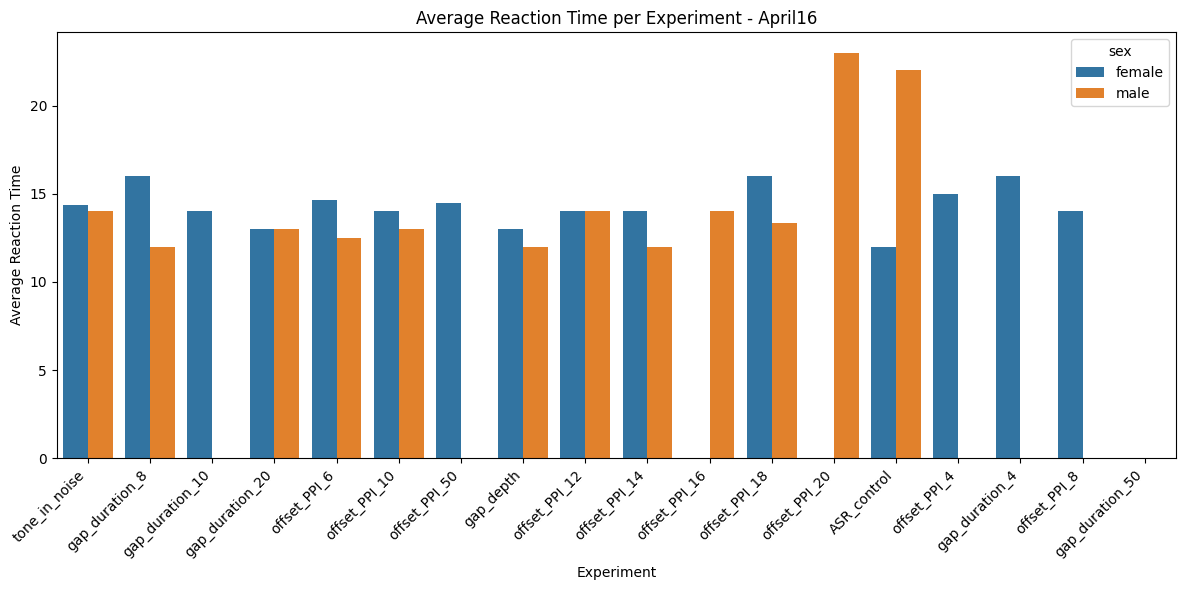

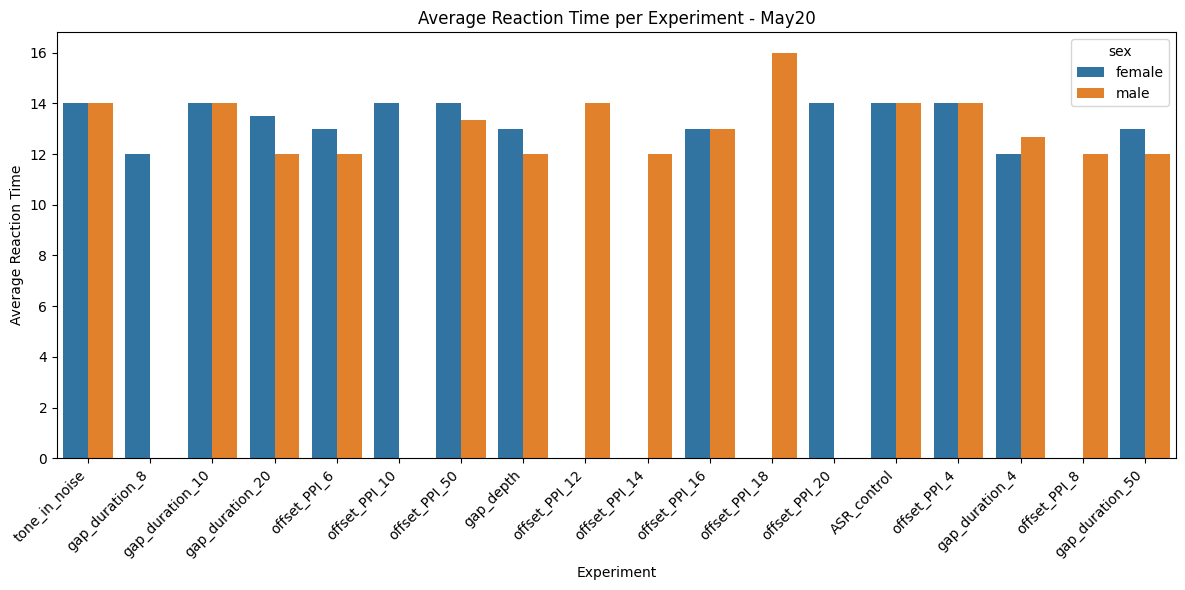

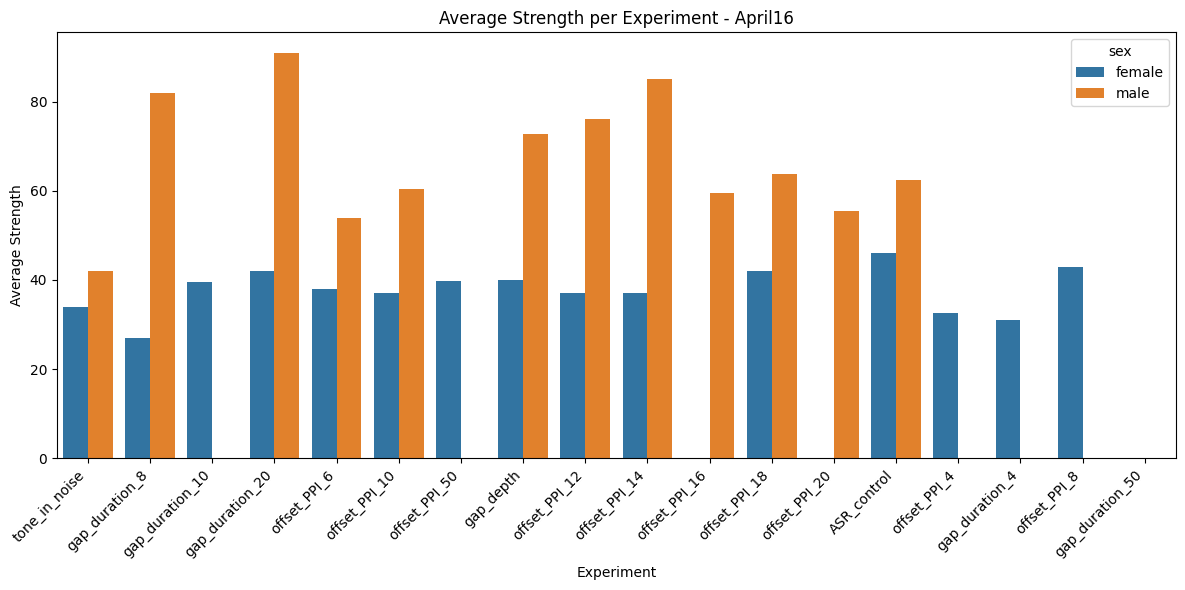

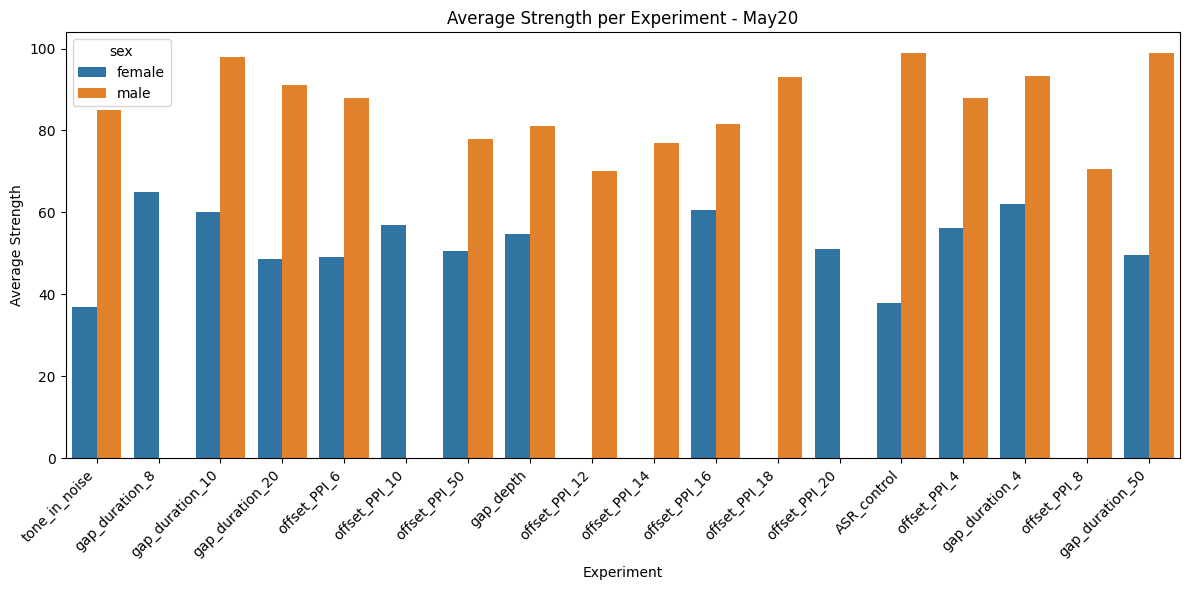

In [35]:
plot_results()
plot_results(strength=True)
plot_results(by_date=True)
plot_results(strength=True, by_date= True)

print("Top 10:")
plot_results(df=df_top_10)
plot_results(df=df_top_10, strength=True)
plot_results(df=df_top_10, by_date=True)
plot_results(df=df_top_10, strength=True, by_date= True)